<h1 align="center"> Image Captioning (8 points) </h1>

In this notebook you will teach a network to do image captioning
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [ ]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb
# from google.colab import drive
# drive.mount('/content/gdrive') 


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("dataset/coco2017_preprocessed/image_codes.npy")
captions = json.load(open('dataset/coco2017_preprocessed/captions_tokenized.json'))

CPU times: user 99.4 ms, sys: 354 ms, total: 453 ms
Wall time: 2.56 s


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [3]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [5]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
# <YOUR CODE HERE>

for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i][1:-1]
        word_num = Counter(sentence)
        for word in word_num:
            word_counts[word] += word_num[word]

In [6]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [7]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [8]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [9]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [35]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=pad_ix) # <YOUR CODE> 
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first = True) # <YOUR CODE>
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens) # <YOUR CODE> 
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix) # <YOUR CODE>
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        # <YOUR_CODE>
        state = (initial_cell[None], initial_hid[None])
        lstm_out, state = self.lstm(captions_emb, state)
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out) # <YOUR_CODE>
        
        return logits

In [ ]:
class CaptionNetV3(nn.Module):
    def __init__(
        self,
        n_tokens=10000,
        emb_size=128,
        pad_ix=0,
        lstm_units=256,
        cnn_in_channels=192,
        feature_size=2048,
        encoded_image_size=14
    ):
        super(self.__class__, self).__init__()

        self.enc = nn.Sequential(
            nn.Conv2d(cnn_in_channels, feature_size, kernel_size=3),
            nn.BatchNorm2d(feature_size),
            nn.ReLU()
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        self.feature_to_h0 = nn.Linear(feature_size, lstm_units)
        self.feature_to_c0 = nn.Linear(feature_size, lstm_units)

        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=pad_ix)
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
        self.logits = nn.Linear(lstm_units, n_tokens)

    def forward(self, image_vectors, captions_ix):
        image_vectors = self.adaptive_pool(self.enc(image_vectors))

        batch_size = image_vectors.size(0)
        encoder_dim = image_vectors.size(1)

        image_vectors = image_vectors.view(batch_size, encoder_dim, -1).mean(dim=-1)

        initial_cell = self.feature_to_h0(image_vectors)
        initial_hid = self.feature_to_c0(image_vectors)

        captions_emb = self.emb(captions_ix)
        state = (initial_cell[None], initial_hid[None])
        lstm_out, state = self.lstm(captions_emb, state)

        logits = self.logits(lstm_out)
        return logits


In [11]:
network = CaptionNet(n_tokens).cuda()

In [12]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec.cuda(), dummy_capt_ix.cuda())

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [13]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    # <YOUR CODE>
    logits_for_next = torch.transpose(logits_for_next, 1, 2)
    loss_fn = nn.CrossEntropyLoss(ignore_index = pad_ix)
    loss = loss_fn(logits_for_next, captions_ix_next).unsqueeze(0)
    
    return loss

In [14]:
dummy_loss = compute_loss(network, dummy_img_vec.cuda(), dummy_capt_ix.cuda())

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.detach().cpu().numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [15]:
optimizer = torch.optim.Adam(network.parameters(), 
                       lr=1e-3,
                       weight_decay = 1e-4) # <YOUR CODE>

# Training

* First implement the batch generator
* Than train the network as usual

In [16]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [17]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32).cuda(), torch.tensor(batch_captions_ix, dtype=torch.int64).cuda()
    

In [18]:
generate_batch(img_codes,captions,3)

(tensor([[0.1193, 1.0701, 0.6672,  ..., 0.2687, 0.7670, 0.0911],
         [0.8003, 0.6819, 1.0292,  ..., 0.3140, 0.2794, 0.5777],
         [0.0552, 0.1963, 0.2147,  ..., 0.1301, 0.6689, 0.1603]],
        device='cuda:0'),
 tensor([[   1,   24,  291,   63,  136,   24, 2785,   15, 1449,   35,  156,   50,
            24,  981,   12,    2],
         [   1,   24,   57,   15,  210,  441, 2230,  239,   35,   24,  858,   12,
             2,    3,    3,    3],
         [   1,   24, 1329, 2430,  716,   35,   73,  158,   15,  716,  330,   45,
           158,    2,    3,    3]], device='cuda:0'))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [19]:
batch_size = 32  # adjust me (done)
n_epochs = 220  # adjust me (done)
n_batches_per_epoch = 40  # adjust me (done)
n_validation_batches = 5  # how many batches are used for validation after each epoch

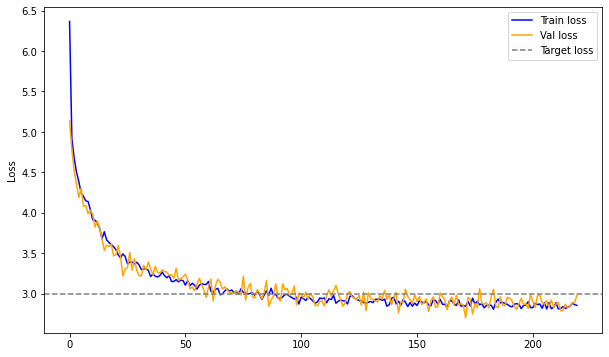

Finished!


In [20]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in range(n_batches_per_epoch):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        # <YOUR CODE>
        # clear old gradients 
        optimizer.zero_grad()
        
        # do a backward pass to get new gradients;
        loss_t.backward()
        
        # then train with opt
        optimizer.step()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    train_losses.append(train_loss)
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    val_losses.append(val_loss)
    
    clear_output()
    plt.figure(figsize = (10, 6))
    plt.plot(train_losses, label = 'Train loss', color = 'blue')
    plt.plot(val_losses, label = 'Val loss', color = 'orange')
    plt.axhline(y=3.0, color='gray', linestyle='--', label = 'Target loss')
    plt.legend()
    plt.ylabel('Loss')
    plt.show()

print("Finished!")

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [22]:
from model.beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/root/.local/lib/python3.6/site-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [23]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
  
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck.cuda(), prefix_ix.cuda())[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.detach().cpu().numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

a laptop computer sitting on top of a desk .
a laptop computer sitting on top of a desk .
a laptop computer sitting on top of a desk .
a computer desk with a laptop computer and a keyboard .
a laptop computer sitting on top of a desk .
a laptop computer sitting on top of a desk .
a laptop computer sitting on top of a desk .
a laptop computer sitting on top of a desk .
a laptop computer sitting on top of a desk .
a laptop computer sitting on top of a desk .


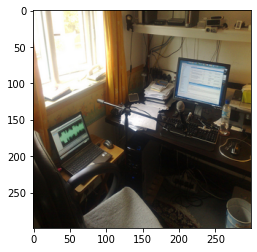

In [34]:
from PIL import Image
import os
import random
#sample image
img_name = random.choice(os.listdir('dataset/coco2017/'))
img = plt.imread(os.path.join('dataset/coco2017/', img_name))
img = Image.fromarray(img).resize((299, 299))
img = np.array(img).astype('float32') / 255.0
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Pretty ok

a group of people sitting at a table with a pizza .
a group of people sitting at a table with a cake .
a group of people sitting around a table with a pizza .
a group of people sitting around a table with a group of people .
a group of people that are sitting at a table .
a group of people sitting at a table with a pizza .
a group of people standing around a table with a cake .
a group of people sitting around a table with a group of people .
a group of people sitting at a table with a pizza .
a group of people sitting around a table with a man and a woman in a kitchen .


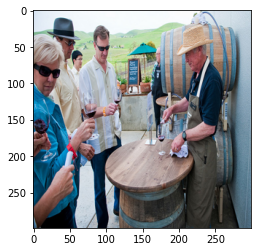

In [28]:
#sample image
img = plt.imread('dataset/coco2017/000000000308.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img).astype('float32') / 255.0
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man and a woman sitting at a table with a woman in the background .
a man in a kitchen with a woman in a kitchen .
a group of people sitting at a table with a wine glass .
a man is sitting at a table with a wine glass .
a group of people sitting at a table with a wine glass .
a group of people sitting at a table with food .
a group of people standing around a table with a wine glass .
a group of people sitting at a table with a wine glass .
a group of people sitting at a table with a wine glass .
a group of people standing around a table with a group of people .


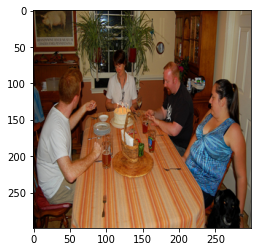

In [29]:
#sample image
img = plt.imread('dataset/coco2017/000000000790.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img).astype('float32') / 255.0
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Nice !)

a man riding a bike on a bike .
a man riding a bike on a bike .
a man riding a bike down a street .
a man riding a bike on a bike .
a man riding a bike on a bike
a man riding a bike on a bike .
a person riding a bike down a street .
a man riding a bike down a street .
a man riding a bike down the street .
a man riding a bike on a bike


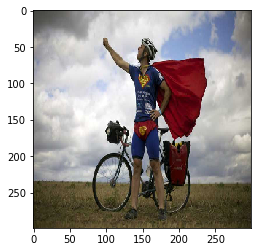

In [ ]:
#sample image
img = plt.imread('/content/gdrive/My Drive/data/bycile_hero.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img).astype('float32') / 255.0
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Pretty ok

a person on a snowboard in a snow covered slope .
a person on a snowboard in the snow .
a person on a snowboard in the snow .
a person on a snowboard in the snow .
a person on a snowboard in a snow covered slope .
a person on a snowboard in the snow .
a person on a snowboard in the snow .
a person on a snowboard in the snow .
a person on a snowboard going down a mountain .
a person on a snowboard in a snow covered slope .


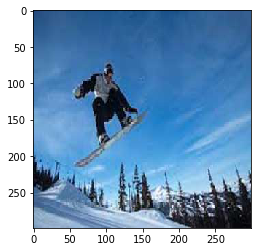

In [ ]:
#sample image
img = plt.imread('/content/gdrive/My Drive/data/snowboard1.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img).astype('float32') / 255.0
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Ok

a man in a black jacket and a black jacket and a snowboard
a man in a black jacket and a black jacket and a black jacket .
a person riding a snowboard down a snowy hill .
a person on a snowboard in the snow .
a person on a snowboard in the snow .
a man riding a snowboard down a snow covered slope .
a person in a suit is skiing on a snowboard .
a person riding a snowboard down a snowy hill .
a person on a snowboard in the snow .
a person on a snowboard in a snow covered in the snow .


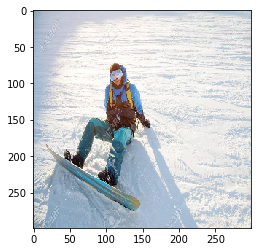

In [ ]:
#sample image
img = plt.imread('/content/gdrive/My Drive/data/snowboard2.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img).astype('float32') / 255.0
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Not bad too

**What about Game of Thrones ?**

a man in a suit and a suit and tie .
a man in a suit and a suit and a tie
a man in a suit and tie in a room .
a man standing in front of a mirror .
a man in a suit and a suit and tie
a man wearing a suit and a suit and tie
a man in a suit and a tie .
a man in a suit and a tie .
a man in a suit and a suit and tie .
a man in a suit and a suit and a tie .


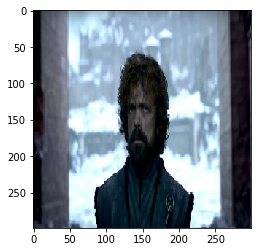

In [ ]:
#sample image
img = plt.imread('/content/gdrive/My Drive/data/GOT_tirion.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img).astype('float32') / 255.0
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Ok

a woman wearing a suit and a tie .
a woman in a suit and a tie in the air .
a woman standing in front of a mirror .
a woman wearing a suit and a tie
a woman standing in a suit holding a cell phone .
a woman wearing a suit and a tie .
a woman with a black tie and a woman standing in front of a mirror .
a woman standing in front of a mirror and a woman in a suit .
a woman holding a cell phone in front of a man .
a woman wearing a suit and a tie .


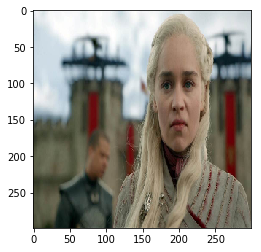

In [ ]:
#sample image
img = plt.imread('/content/gdrive/My Drive/data/GOT_angry_deny.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img).astype('float32') / 255.0
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Not so bad)

a man in a suit and a black shirt and a skateboard .
a man in a suit and a hat and a skateboard .
a man is sitting on a skateboard on a skateboard .
a man with a skateboard in his hand .
a man is doing a trick on a skateboard .
a man is holding a skateboard in the air .
a man is sitting on a skateboard in the middle of a building .
a man with a skateboard on a skateboard .
a man with a skateboard in a suit .
a man in a suit and a black shirt and a skateboard .


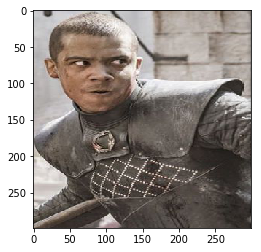

In [ ]:
#sample image
img = plt.imread('/content/gdrive/My Drive/data/GOT_gray_warm.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img).astype('float32') / 255.0
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Probably, a texture on Gray Warm chest looks like skateboard for the NN

a bird is sitting in a tree with a clock .
a bird sitting on a tree with a tree in the background .
a bird that is sitting on a tree .
a bird is perched on a tree branch .
a bird is perched on a tree in a tree .
a bird sitting on a tree near a tree .
a bird is perched on a branch of a tree .
a bird is standing on a tree with a tree .
a bird is perched on a tree with a tree .
a bird is perched on a branch of a tree .


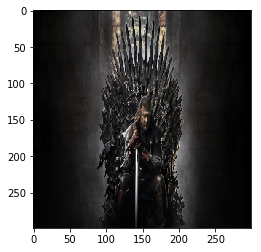

In [ ]:
#sample image
img = plt.imread('/content/gdrive/My Drive/data/GOt_iron_throne.jpeg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img).astype('float32') / 255.0
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

A black throne really looks like a bird!)

a man holding a baseball bat and a bat
a man standing in a field with a baseball bat .
a man holding a baseball bat and a bat .
a man with a baseball bat and a bat .
a man standing in a field with a kite .
a man in a suit and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black and white shirt and a black and white photo of a man in the background .
a man in a suit and a black shirt and a black shirt and a black shirt and a black and white shirt and a black and white photo of a man in the background .
a man in a suit and a baseball uniform and a baseball
a man in a suit and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt .
a man holding a baseball bat and a ball in the background .


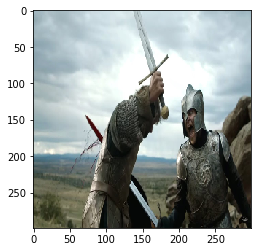

In [ ]:
#sample image
img = plt.imread('/content/gdrive/My Drive/data/GOT_fight.jpg')
img = Image.fromarray(img).resize((299, 299))
img = np.array(img).astype('float32') / 255.0
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

NN thinks that a sword is a baseball bat. Not so bad taking into account that probably NN has never seen a sword.
Also T-shirt is similar to chain mail